# Monte Carlo estimation of Sensitivities in Finance
## MATH-414 Stochastic Simulation project
Authors : Charles Gendreau - Eliott Van Dieren

Professor : Prof. Fabio Nobile

Teaching Assistant : Sundar Ganesh

In [22]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

In [59]:
# Utility functions

def simul_S_T(params:list,n:int,W_T : np.array) -> np.array:
    """
    Returns a numpy array of size n with prices of the underlying at maturity
    
    Args :
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
        - n : number of prices (int)
    Returns :
        - numpy array of S_T
    """
    T : float = params[0]; S_0 : float = params[1]
    r : float = params[2]; sig : float = params[3]
    #W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(T),size=n)
    return S_0*np.exp((r-0.5*sig**2)*T+sig*W_T)


def CMC_estimator(func,X:np.array,params:list) -> list:
    """
    Crude Monte-Carlo estimator of E[func(X)]
    
    args:
        - func : function from R^N to R^N where N = length of X
        - X : numpy array
    returns : 
        - Crude Monte-Carlo estimator of the mean
        - Standard deviation (for CI purposes)    
    """
    return [np.mean(func(X,params)),np.std(func(X,params))]

def finite_difference(func,params:list,dtheta:float,derivative:str, n:int) -> float:
    """
    Finite difference method to compute the derivative of I := E[func(X)] wrt theta
    
    I is computed with the CMC_estimator function which takes func and S_T as argument
    
    args:
        - func : function from R^N to R^N which takes S_T as parameter (payoff function)
        - params is a list of the following values :
            * T : Time of maturity in years (float)
            * S_0 : Underlying price at time 0 (float)
            * r : free-risk interest rate (float)
            * sig : Volatility of the underlying (float)
            * K : Strike price for the payoff
        - dtheta : small delta of theta to compute the finite difference (float)
        - derivative : either "delta", "vega" or "gamma"
        - n : number of simulations for Monte-Carlo
        
    returns : the estimated value of dI/dtheta by finite difference method
    
    """
    
    if derivative not in ["delta","vega","gamma"]:
        print(f"Derivative not supported : {derivative}")
        raise ValueError
    
    idx_deriv : int = 3 if derivative == "vega"  else 1 # Useful to know which parameter we have to modify
    
    # Definition of new parameters
    params_pos : list = params.copy(); params_neg : list = params.copy()
    params_pos[idx_deriv] += dtheta ; params_neg[idx_deriv] -= dtheta
    
    # Generation of Stock prices
    W_T : np.array = st.norm.rvs(loc=0,scale=np.sqrt(params[0]),size=n)
    S_T_pos : np.array = simul_S_T(params_pos,n,W_T) ; S_T_neg = simul_S_T(params_neg,n,W_T)
    
    # Generation of payoff estimates
    [payoff_mu_pos,payoff_std_pos] = CMC_estimator(func,S_T_pos,params)
    [payoff_mu_neg,payoff_std_neg] = CMC_estimator(func,S_T_neg,params)

    if derivative == "gamma": # Due to different equation for second order derivative estimates
        S_T : np.array = simul_S_T(params,n,W_T); [payoff_mu,payoff_std] = CMC_estimator(func,S_T,params)
        return (payoff_mu_pos -2*payoff_mu + payoff_mu_neg)/(dtheta**2)
    else: # For delta and vega
        return 0.5*(payoff_mu_pos-payoff_mu_neg)/dtheta

## 3. Application to option pricing

### 3.1 European Call Option

In [86]:
# Parameters
T = 1
S_0 = 100
K = 120
r = 0.05
sig = 0.25
params = [T,S_0,r,sig,K]
dtheta = 1e-5

# Payoff function for European Call Option
C_payoff = lambda x,p: np.exp(-p[2]*p[0])*np.maximum(x-p[4],np.zeros(len(x)))

In [90]:
n_elem = np.arange(10**3,10**5+1000,1000)

# Finite difference method

delta_finite = np.zeros(len(n_elem))
vega_finite = np.zeros(len(n_elem))
gamma_finite = np.zeros(len(n_elem))
for idx,n in enumerate(n_elem):
    delta_finite[idx] = finite_difference(C_payoff,params,dtheta,"delta", n)
    vega_finite[idx] = finite_difference(C_payoff,params,dtheta,"vega", n)
    gamma_finite[idx] = finite_difference(C_payoff,params,dtheta,"gamma", n)

In [91]:
d1 = (np.log(S_0/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))

print("Estimated delta value : ", delta_finite[-1])
print("real delta value : ",st.norm.pdf(d1))

print("Estimated gamma value : ", gamma_finite[-1])
print("real gamma value : ",np.exp(-r*T)*st.norm.pdf(d1)/(sig*S_0*np.sqrt(T)))

print("Estimated vega value : ", vega_finite[-1])
print("real vega value : ",np.exp(-r*T)*S_0*np.sqrt(T)*st.norm.pdf(d1))

Estimated delta value :  0.34263383201782455
real delta value :  0.3676359083901262
Estimated gamma value :  -8.88178419700125e-06
real gamma value :  0.01398824374254948
Estimated vega value :  37.1164949873215
real vega value :  34.9706093563737


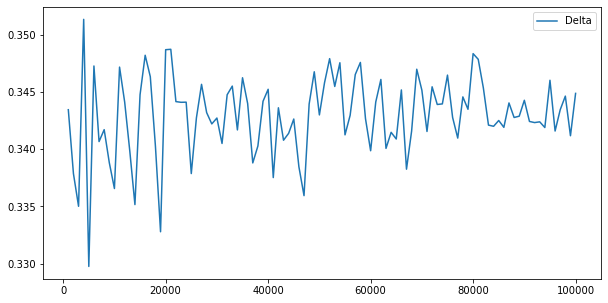

In [89]:
plt.figure(figsize=(10,5))
plt.plot(n_elem,delta_finite,label="Delta")
#plt.plot(n_elem,vega_finite,label="Vega")
#plt.plot(n_elem,gamma_finite,label="Gamma")
plt.legend()
plt.show()

Comments :

Le gamma blow up totalement

Quelle valeur de $\Delta \theta$ choisir?

In [64]:
#finite_difference(C_payoff,params,dtheta,"delta", 5*10**7)

0.34301139607784137